<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/NB_Clustering_LC2_Fuiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clustering con scikit-learn#


Scopo: familiarizzare con l'implementazione di algoritmi di clustering usando il package scikit-learn.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Parte 1: confronto e visualizzazione di differenti algoritmi di clsutering disponibili in scikit-learn ###

* esempio da scikit-learn: [link](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

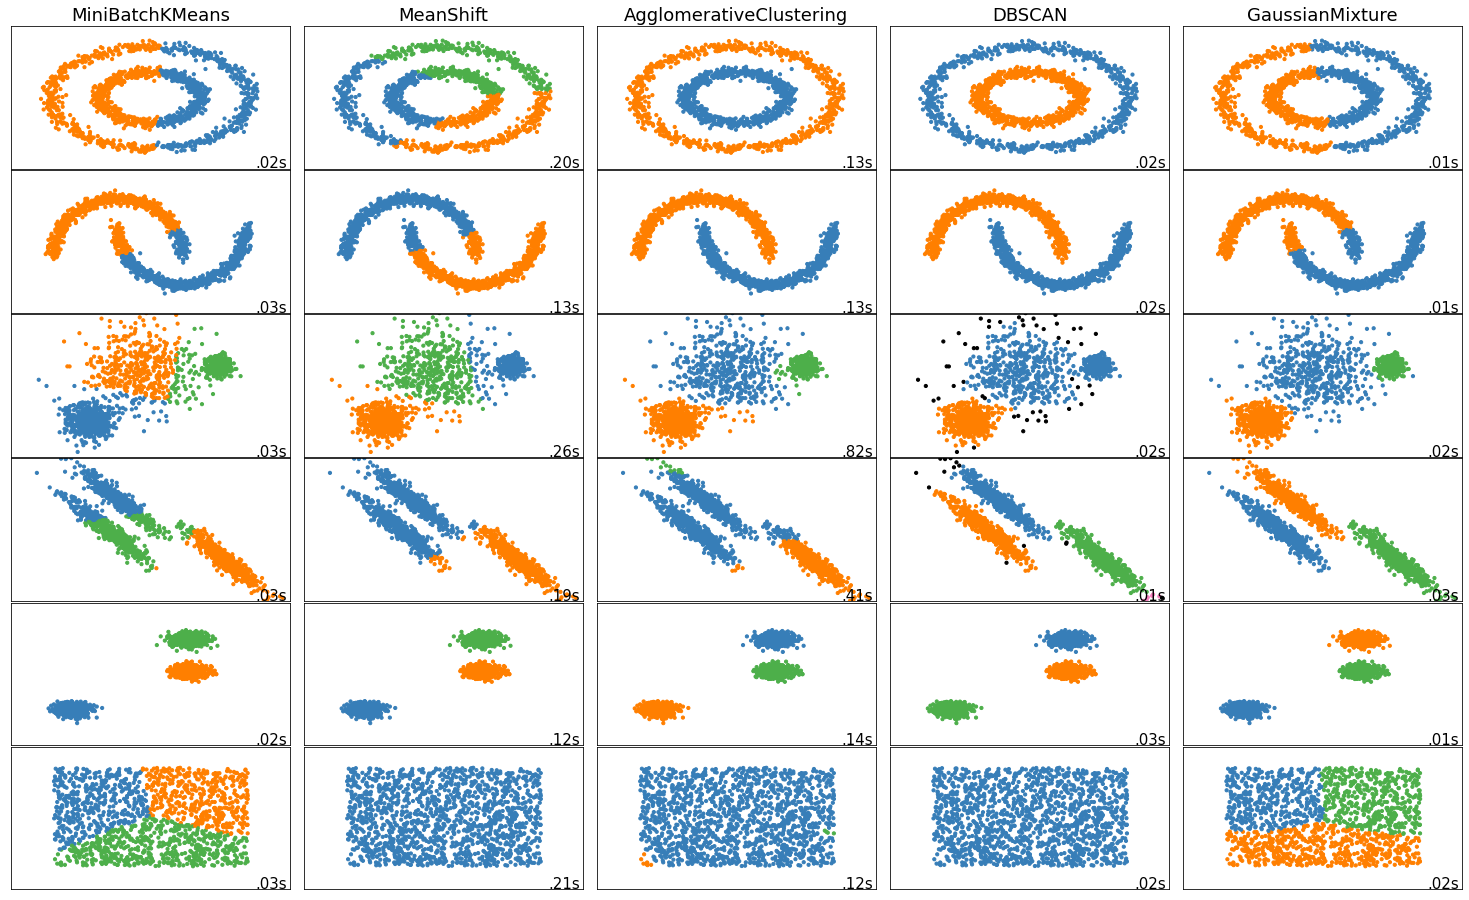

In [0]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate different toy datasets. We choose the size big enough to see the 
# scalability of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        # k-means (con mini-batch)
        ('MiniBatchKMeans', two_means),
        #('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        #('SpectralClustering', spectral),
        #('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        #('OPTICS', optics),
        #('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Analisi risultati: ###

* DBSCAN tipicamente funziona meglio degli altri algoritmi dal punto di vista dell'accuracy nelle predizioni ma fallisce nel terzo dataset

> NOTA: gli algoritmi basati sulla densità dei punti, quindi basati su informazioni locali, funzionano bene con dataset in cui i punti di una stessa classe sono connessi tra loto (dataset topologici), come quelli della righe 1,2, mentre possono avere problemi con dataset con grandi fluttuazioni nelle distribuzioni di densità del dataset *terza riga), e scalano male con alta dimensionalità delle feature

* gli algoritmi basati su metriche di distanza (tipo k-means) invece funzionano male su i primi due dataset e ovviamente quando il numero di cluster impostato è lontano dal valore vero (ultima distribuzione).


### Parte 2: Applicazione ad un dataset reale e analisi dei risultati con l'algoritmo k-means ###

Dataset: World Happiness Report 2016

The World Happiness Report is a landmark survey of the state of global happiness.

The happiness scores and rankings use data from the Gallup World Poll. The scores are based on answers to the main life evaluation question asked in the poll.

The columns following the happiness score estimate the extent to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors. They have no impact on the total score reported for each country, but they do explain why some countries rank higher than others.

In [0]:
#leggiamo il dataset con pandas

import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/2016.csv')
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789


In [0]:
# controllo sul contenuto

#lista delle feature (per la selezione nel dataframe pandas)

sel_features = ['Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']

In [0]:
pinco = data.loc[data['Family']>1.1]
pinco['Happiness Score']

0     7.526
1     7.509
2     7.501
3     7.498
4     7.413
7     7.334
8     7.313
18    6.907
36    6.361
48    5.987
69    5.538
Name: Happiness Score, dtype: float64

In [0]:
# summary statistic del dataset

data[sel_features].describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


In [0]:
# controllo sulla correlazione dei dati

data[sel_features].corr()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Economy (GDP per Capita),1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


alcune feature mostrano una certa correlazione ...

In [0]:
# visualizzazione con t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# sklearn tSNE con pre-pca applicata 
# typical value for perplexity between 5 and 50 (should be tested)
tsne = TSNE(n_components=2, init='pca', perplexity = 10)
tsne_data = tsne.fit_transform(data[sel_features])

In [0]:
# salviamo i risultati nel dataframe

data['tsne-one'] = tsne_data[:,0]
data['tsne-two'] = tsne_data[:,1]
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,0.818631,-41.273136
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,-1.366023,-41.301208
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,-5.991512,-38.532486
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,-0.687390,-39.445026
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,0.011341,-43.163250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812,16.020624,33.490944
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558,16.703823,31.446390
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540,17.603022,33.462196
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789,-21.396935,19.847120


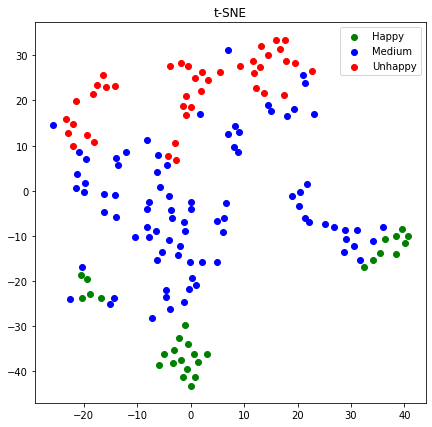

In [0]:
#plot dei risultati
plt.figure(figsize=(7,7))

happy = data.loc[data['Happiness Score']>=6.5]
medium = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<6.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
plt.scatter(medium['tsne-one'], medium['tsne-two'], c='blue', label='Medium')
plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
plt.legend()
plt.title('t-SNE');

si notano due gruppi distinti di paesi felici ... andiamo a controllare

In [0]:
happy.loc[data['tsne-one']>10]

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
10,Israel,Middle East and Northern Africa,11,7.267,7.199,7.335,1.33766,0.99537,0.84917,0.36432,0.08728,0.32288,3.31029,38.378937,-14.061131
13,Costa Rica,Latin America and Caribbean,14,7.087,6.999,7.175,1.06879,1.02152,0.76146,0.55225,0.10547,0.22553,3.35168,35.477821,-13.763563
14,Puerto Rico,Latin America and Caribbean,15,7.039,6.794,7.284,1.35943,1.08113,0.77758,0.46823,0.12275,0.22202,3.00760,40.067146,-11.575621
16,Brazil,Latin America and Caribbean,17,6.952,6.875,7.029,1.08754,1.03938,0.61415,0.40425,0.14166,0.15776,3.50733,34.105885,-15.301084
20,Mexico,Latin America and Caribbean,21,6.778,6.680,6.876,1.11508,0.71460,0.71143,0.37709,0.18355,0.11735,3.55906,32.480446,-16.993153
23,Chile,Latin America and Caribbean,24,6.705,6.615,6.795,1.21670,0.90587,0.81883,0.37789,0.11451,0.31595,2.95505,39.464314,-8.413197
24,Panama,Latin America and Caribbean,25,6.701,6.601,6.801,1.18306,0.98912,0.70835,0.48927,0.08423,0.24180,3.00559,38.414921,-10.049417
25,Argentina,Latin America and Caribbean,26,6.650,6.560,6.740,1.15137,1.06612,0.69711,0.42284,0.07296,0.10989,3.12985,36.271248,-10.698177
26,Czech Republic,Central and Eastern Europe,27,6.596,6.515,6.677,1.30915,1.00793,0.76376,0.41418,0.03986,0.09929,2.96211,40.672615,-10.071486


In [0]:
happy.loc[data['tsne-one']<10]

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,tsne-one,tsne-two
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,0.818631,-41.273136
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,-1.366023,-41.301208
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,-5.991512,-38.532486
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,-0.687390,-39.445026
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,0.011341,-43.163250
5,Canada,North America,6,7.404,7.335,7.473,1.44015,1.09610,0.82760,0.57370,0.31329,0.44834,2.70485,-1.786754,-37.532829
6,Netherlands,Western Europe,7,7.339,7.284,7.394,1.46468,1.02912,0.81231,0.55211,0.29927,0.47416,2.70749,-3.260576,-38.198681
7,New Zealand,Australia and New Zealand,8,7.334,7.264,7.404,1.36066,1.17278,0.83096,0.58147,0.41904,0.49401,2.47553,2.980772,-36.246441
8,Australia,Australia and New Zealand,9,7.313,7.241,7.385,1.44443,1.10476,0.85120,0.56837,0.32331,0.47407,2.54650,0.660523,-36.281292
9,Sweden,Western Europe,10,7.291,7.227,7.355,1.45181,1.08764,0.83121,0.58218,0.40867,0.38254,2.54734,1.458367,-37.954338


In [0]:
# Visualizzazione con PCA

from sklearn.decomposition import PCA

#consideriamo solo le prime tre componenti
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data[sel_features].values)

data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#NOTA: l'explained variation indica quanto ciascuna componente contribusice alla varianza totale del campione

Explained variation per principal component: [0.47971059 0.37710712 0.0571725 ]


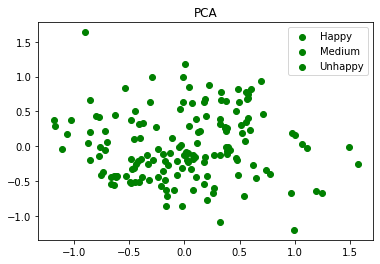

In [0]:
happy = data.loc[data['Happiness Score']>=6.5]
medium = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<6.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['pca-one'], happy['pca-two'], c='green', label='Happy')
plt.scatter(medium['pca-one'], medium['pca-two'], c='green', label='Medium')
plt.scatter(unhappy['pca-one'], unhappy['pca-two'], c='green', label='Unhappy')
plt.legend()
plt.title('PCA');

In [0]:
#Clustering using k-means

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=20, max_iter=600, 
    tol=1e-04, random_state=0
)
y_km = km.fit(data[sel_features].values)
y_pred = y_km.labels_.astype(np.int)

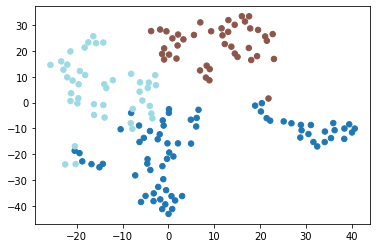

In [0]:
#confronto con tSNE
ax = plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=y_pred, cmap='tab20')

Proviamo a scegliere k andando ad analizzare se i dati indicano qualche preferenza specifica, questo può essere fatto sia guardando alla **distortion** (metodo dell'elbow): *somma delle distanze quadratiche dei campioni dai centri dei cluster più vicini*. 

Ci aspettiamo che la distortion subisca un cambio di pendenza una volta raggiunto il k ottimale ...

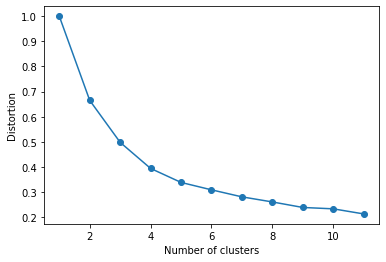

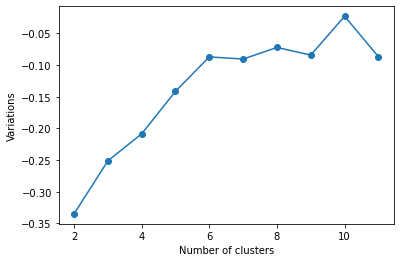

In [0]:
# calcoliamo il best k usando la distorsione
# NOTA: distorsione: Sum of squared distances of samples to their closest cluster center
k_max=12
distortions = []
variations = []
old = 0
for i in range(1, k_max):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=20, max_iter=600,
        tol=1e-04, random_state=0
    )
    km.fit(data[sel_features].values)
    
    distortions.append(km.inertia_)
    if (i>1):
       variations.append((km.inertia_-old)/old)
    old = km.inertia_

# plot
plt.plot(range(1, k_max), distortions/distortions[0], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
plt.plot(range(2, k_max), variations, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Variations')
plt.show()

indicazione di un k tra 4 e 6.

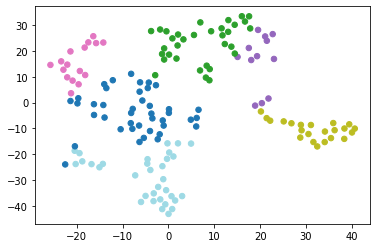

In [0]:
#Clustering using k-means

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=6, init='k-means++',
    n_init=20, max_iter=600, 
    tol=1e-04, random_state=0
)
y_km = km.fit(data[sel_features].values)
y_pred = y_km.labels_.astype(np.int)

ax = plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=y_pred, cmap='tab20')


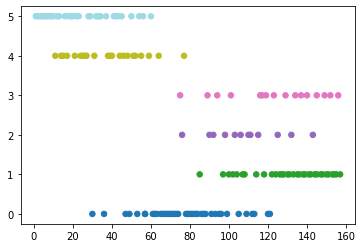

In [0]:
ax = plt.scatter(data['Happiness Rank'],y_pred, s=30, c=y_pred, cmap='tab20')

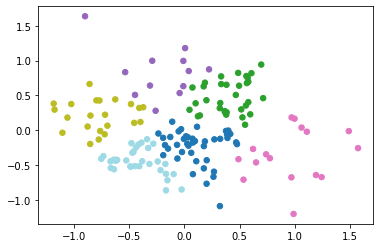

In [0]:
ax = plt.scatter(data['pca-one'],data['pca-two'], s=30, c=y_pred, cmap='tab20')

### Esercizi: ###

* testare i vari algoritmi di clustering in funzione dei loro parametri

* indentificare quali tra le feature del World Happines report dataset forniscono i maggior contributo all'Happines Rank: i.e. cosa rende un paese felice?

#Esercizio 1: Test algoritmi di clustering
Si esplorano tutti gli algoritmi di clustering proposti per comprendere quali siano più efficienti in quali casi.

Analizziamo dunque l'efficacia degli algoritmi sui vari tipi di dataset.
>NOTA: Si analizzeranno le prestazioni degli algoritmi in relazione a tutti i dataset meno il quinto ($\textit{blobs}$), che risulta facile da clusterizzare da tutti gli algoritmi proposti. <br />


Per i dataset topologici gli algoritmi più performanti sono in genere quelli basati sulla densità di punti, ovvero quelli basati su info locali. A riprova di questo, i migliori da usare in questo caso risultano:<br />
* Spectral Clustering;
* Agglomerative Clustering;
* DBSCAN;
* Optics. <br />

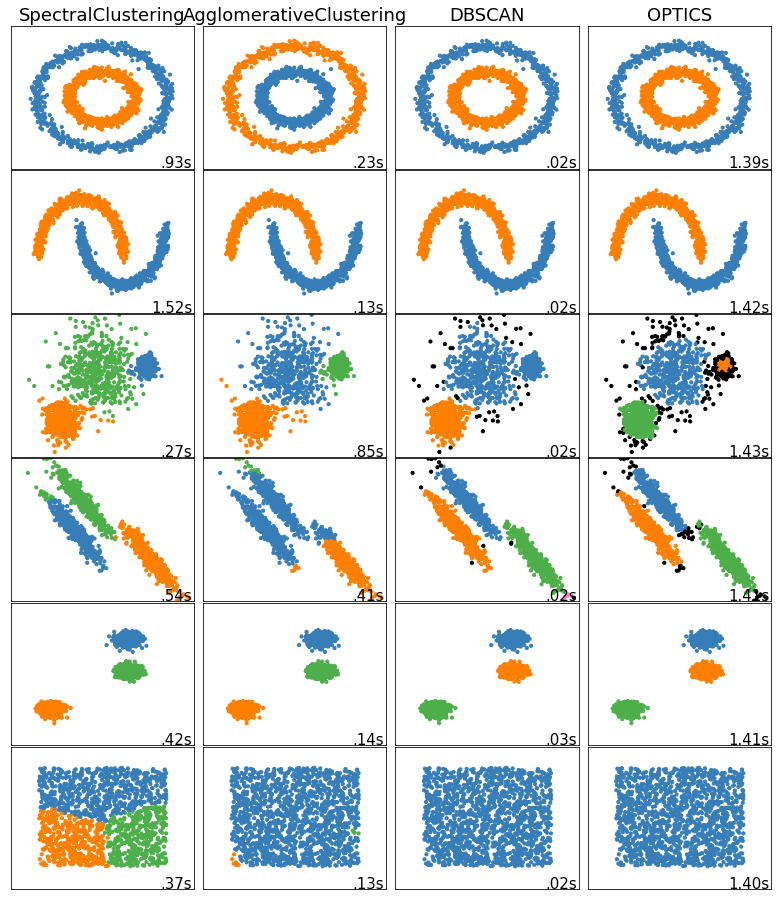

In [0]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(11, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        #('AffinityPropagation', affinity_propagation),
        ('SpectralClustering', spectral),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Tra essi, il migliore risulta essere DBSCAN, almeno in una prima analisi. Esso ha come unico problema l'inadeguatezza a clusterizzare in maniera ottimale dataset con grandi fluttuazioni (vedasi terza e quarta riga), nei quali commette diversi errori di valutazione. Più adatto in tal caso l'algoritmo optics. Quest'ultimo, a fronte di una discreta adeguatezza per il clustering di dataset a grandi fluttuazioni, presenta un tempo computazionale di gran lunga superiore a DBSCAN (Optics $\simeq 1.4s$, DBSCAN $\simeq 0.02s$) e diversi outliers. Ciò è probabilmente dovuto ad un'incertezza nell'assegnazione. <br />
Algoritmi che clusterizzano bene il $\textit{varied dataset}$ avendo inoltre buone prestazioni sui topologici sono l'agglomerative e lo spectral clustering. <br />
L' $\textit{aniso dataset}$ è invece, come già detto, ben clusterizzato da DBSCAN e optics, a fronte di diversi outliers (in nero). Un algoritmo che risulta meno preciso nel suddetto dataset ma assegna tutti i dati ai cluster è lo spectral clustering. Lo spectral, però, a differenza dell'agglomerative, non classifica come cluster singolo l'ultimo dataset, nel quale forza una divisione a tre cluster. <br />
In ultima analisi, se si volesse un algoritmo tra i proposti nell'elenco di cui sopra da utilizzare indipendentemente dal tipo di dataset, probabilmente il più adatto sarebbe DBSCAN, anche se purtroppo fallisce in dati con grandi variazioni. Se si potesse avere a disposizione grande potenza di calcolo si potrebbe scegliere anche Optics, al quale si preferisce DBSCAN solo per il minor tempo computazionale utilizzato.

Analizziamo quindi i restanti algoritmi:
* MiniBatch Kmeans
* Affinity Propagation
* Mean Shift
* Ward
* Birch
* Gaussian Mixture


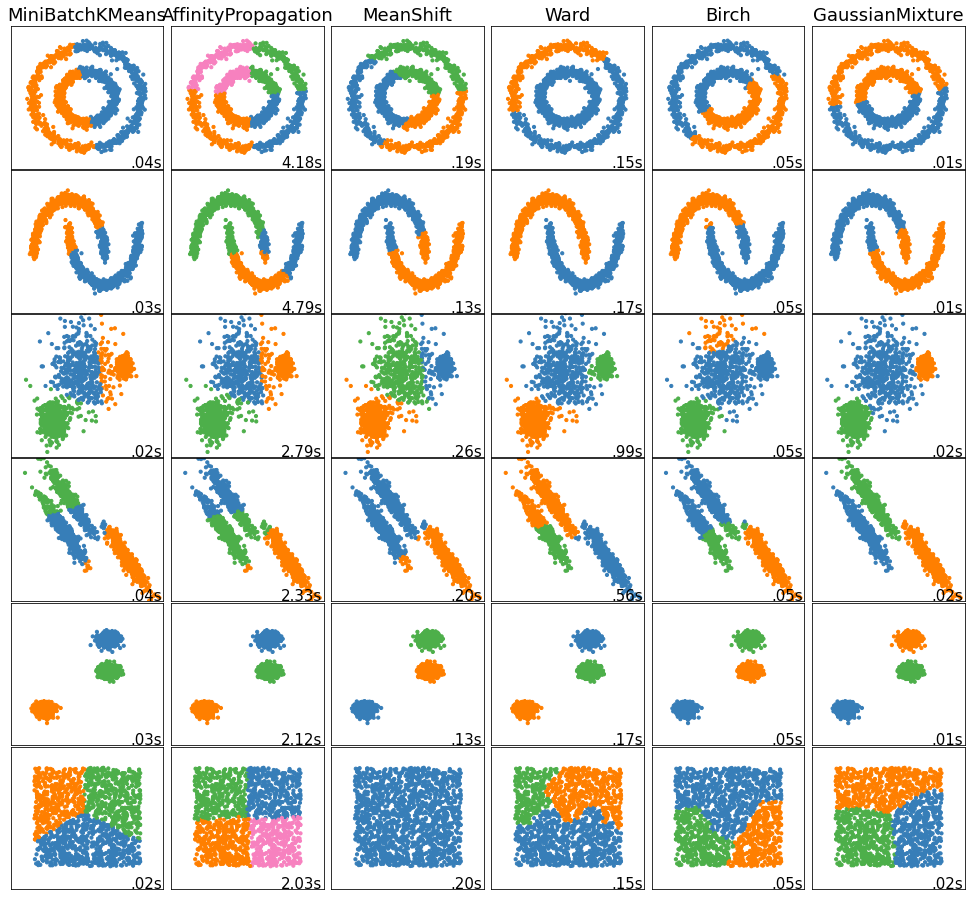

In [0]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 1.2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]


# loop su i 6 datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

# Algoritmi di clustering per il confronto
    clustering_algorithms = (
        # k-means (con mini-batch)
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        #('SpectralClustering', spectral),
        ('Ward', ward),
        #('AgglomerativeClustering', average_linkage),
        #('DBSCAN', dbscan),
        #('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Come prevedibile per algoritmi legati alla distanza tra punti o per algoritmi gerarchici, i dataset topologici vengono clusterizzati erroneamente. <br />
Non tenendo conto dei dataset topologici, per il secondo dei quali (mezze lune) l'unico algoritmo a clusterizzare correttamente è ward, si osservano le prestazioni per i restanti dataset. <br />
Si nota subito come Birch sia in assoluto il meno preciso degli algoritmi. Essendo esso di tipo gerarchico ed essendo ottimizzato per dataset particolarmente grandi, si può pensare la sua fallacia nei risultati possa essere data dal numero di samples relativamente esiguo. <br />
Mini batch k-means e mean shift sono adeguati per il clustering del terzo dataset e in generale Mini batch k-means sembra in ogni caso adeguato ad identificare il numero corretto di clusters (fatta eccezione dell'ultimo dataset, clusterizzato correttamente, invece, da mean shift). L'imprecisione di Mini batch k-means può, come nel caso di Birch, essere dovuta alla carenza di dati, in quanto esso è ottimizzato per dataset imponenti. <br />
Essendo basato su k-means, come Mini batch, anche Gaussian Mixture individua sempre il numero corretto di clusters, ed eccelle nei dataset che si stanno trattando, compreso il quarto, che mette in difficoltà tutti gli altrialgoritmi. L'unico dataset, oltre ai primi due, topologici, a mettere in difficoltà GM è la distribuzione uniforme. Questa disorienta, come visto, tutti gli algoritmi analizzati tranne Mean Shift. Gaussian Mixture è inoltre l'algoritmo che richiede meno tempo di lavoro in assoluto ($\simeq 1s$ per dataset).<br />
Affinity propagation ha infine delle prestazioni decisamente deludenti. La fallacia della clusterizzazione operata da tale algoritmo potrebbe essere legata alla sua eccessiva complessità, inadeguata ad un problema semplice come quello affrontato qui. E' inoltre il più dispendioso in termini di risorse computazionali.

#Esercizio 2: Cosa rende un paese felice?

Si ripete anzitutto l'analisi già operata in precedenza sul dataset, per avere a disposizione una rappresentazione comoda dei dati.

In [0]:
#leggiamo il dataset con pandas

import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/2016.csv')
sel_features = ['Economy (GDP per Capita)','Family','Health (Life Expectancy)','Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']
data

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Benin,Sub-Saharan Africa,153,3.484,3.404,3.564,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812
153,Afghanistan,Southern Asia,154,3.360,3.288,3.432,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558
154,Togo,Sub-Saharan Africa,155,3.303,3.192,3.414,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540
155,Syria,Middle East and Northern Africa,156,3.069,2.936,3.202,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789


In [0]:
# summary statistic del dataset

data[sel_features].describe()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.953880,0.793621,0.557619,0.370994,0.137624,0.242635,2.325807
std,0.412595,0.266706,0.229349,0.145507,0.111038,0.133756,0.542220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.817890
25%,0.670240,0.641840,0.382910,0.257480,0.061260,0.154570,2.031710
50%,1.027800,0.841420,0.596590,0.397470,0.105470,0.222450,2.290740
75%,1.279640,1.021520,0.729930,0.484530,0.175540,0.311850,2.664650
max,1.824270,1.183260,0.952770,0.608480,0.505210,0.819710,3.837720


In [0]:
# controllo sulla correlazione dei dati
data[sel_features].corr()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Economy (GDP per Capita),1.000000,0.669540,0.837067,0.362283,0.294185,-0.025531,0.068624
Family,0.669540,1.000000,0.588377,0.450208,0.213561,0.089629,0.119672
Health (Life Expectancy),0.837067,0.588377,1.000000,0.341199,0.249583,0.075987,0.100857
Freedom,0.362283,0.450208,0.341199,1.000000,0.502054,0.361751,0.091631
Trust (Government Corruption),0.294185,0.213561,0.249583,0.502054,1.000000,0.305930,-0.002909
Generosity,-0.025531,0.089629,0.075987,0.361751,0.305930,1.000000,-0.133001
Dystopia Residual,0.068624,0.119672,0.100857,0.091631,-0.002909,-0.133001,1.000000


Alcune feature mostrano una certa correlazione: Economy e Health sembrano particolarmente interdipendenti. Si vuole utilizzare questa informazione per l'analisi che ci si appresta ad operare tramite il clustering.

In [0]:
# visualizzazione con t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# sklearn tSNE con pre-pca applicata 
# typical value for perplexity between 5 and 50 (should be tested)
tsne = TSNE(n_components=2, init='pca', perplexity = 10)
tsne_data = tsne.fit_transform(data[sel_features])
data['tsne-one'] = tsne_data[:,0]
data['tsne-two'] = tsne_data[:,1]

Prima del plot grafico dei dati si usa il metodo dell'elbow per individuare il numero corretto di clusters. Si attende un cambio di pendenza nella distortion in prossimità del k ottimale.

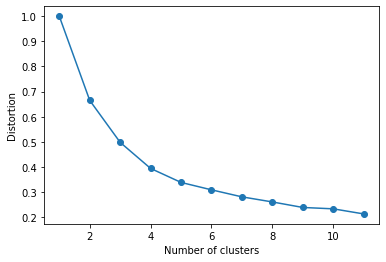

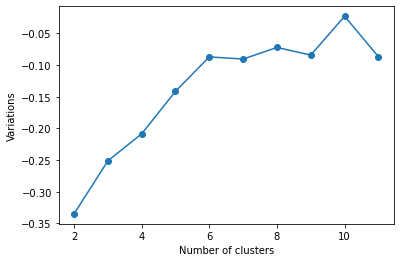

In [0]:
# calcoliamo il best k usando la distorsione
k_max=12
distortions = []
variations = []
old = 0
for i in range(1, k_max):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=20, max_iter=600,
        tol=1e-04, random_state=0
    )
    km.fit(data[sel_features].values)
    
    distortions.append(km.inertia_)
    if (i>1):
       variations.append((km.inertia_-old)/old)
    old = km.inertia_

# plot
plt.plot(range(1, k_max), distortions/distortions[0], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
plt.plot(range(2, k_max), variations, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Variations')
plt.show()

indicazione di un k tra 4 e 6. Si sceglie momentaneamente un numero di cluster pari a 4, ipotizzando una possibile divisione dei paesi in "fasce" di felicità crescente (infelici, medio-infelici, medio-felici, felici).

Si utilizzano algoritmi di clustering basati sulle distanze e sulle densità, nonostante non si è davanti ad un dataset topologico, al fine di testarle ancora una volta le differenze tra loro. Si utilizzano quindi Mini-batch K-means, Gaussian Mixture, DBSCAN e Spectral clustering (se ne prendono 2 da ogni "gruppo" analizzato al punto precedente). <br />



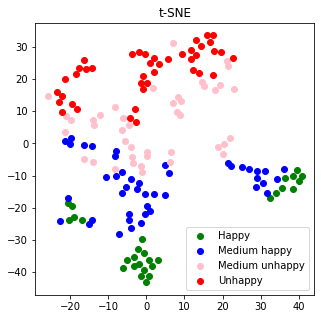

In [0]:
#plot dei risultati
plt.figure(figsize=(5,5))

happy = data.loc[data['Happiness Score']>=6.5]
medium_ha = data.loc[(data['Happiness Score']>5.5) & (data['Happiness Score']<6.5)]
medium_un = data.loc[(data['Happiness Score']>4.5) & (data['Happiness Score']<=5.5)]
unhappy = data.loc[data['Happiness Score']<=4.5]

plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
plt.scatter(medium_ha['tsne-one'], medium_ha['tsne-two'], c='blue', label='Medium happy')
plt.scatter(medium_un['tsne-one'], medium_un['tsne-two'], c='pink', label='Medium unhappy')
plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
plt.legend()
plt.title('t-SNE');

Clustering con Mini-batch K-means:

In [0]:
#Clustering using Mini-batch k-means
from sklearn.cluster import KMeans
n_clusters = 4
#After several tests we decide the best batch size for this problem is 20
minik = cluster.MiniBatchKMeans(n_clusters=n_clusters,
                                batch_size=20, random_state=0,
                                tol=1e-4, n_init=10)

minik_fit = minik.fit(data[sel_features].values)
minik_pred = minik_fit.labels_.astype(np.int)

Clustering usando Gaussian Mixture

In [0]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
#Gaussian Mixture


gmm = GaussianMixture(n_components=n_clusters, 
                      max_iter=3000, 
                      init_params='kmeans')
gmm.fit(data[sel_features].values)
gmm_scores = gmm.score_samples(data[sel_features].values)
gmm_pred = gmm.predict(data[sel_features].values)

Clustering con DBSCAN

In [0]:

#DBSCAN
db = cluster.DBSCAN(eps=params['eps'])
db.fit(data[sel_features].values)
db_scores = gmm.score_samples(data[sel_features].values)
db_pred = gmm.predict(data[sel_features].values)

Clustering con Spectral clustering

In [0]:
#Spectral Clustering
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
spectral.fit(data[sel_features].values)
spectral_scores = gmm.score_samples(data[sel_features].values)
spectral_pred = gmm.predict(data[sel_features].values)



Si confrontano dunque i risultati ottenuti con gli algoritmi di clustering.

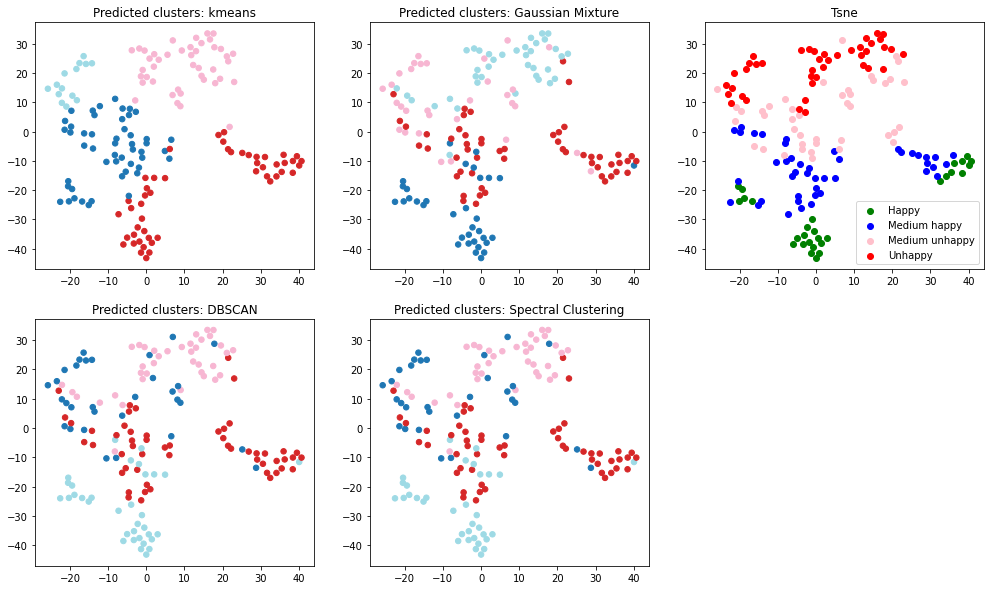

In [0]:
plt.close()
plt.figure(figsize=(17,10))
#Confronto grafico
ax1 = plt.subplot(2, 3, 1)
ax1= plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=minik_pred, cmap='tab20')
ax1 = plt.title('Predicted clusters: kmeans')
ax2 = plt.subplot(2, 3, 2)
ax2=plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=gmm_pred, cmap='tab20')
ax2 = plt.title('Predicted clusters: Gaussian Mixture')
ax1 = plt.subplot(2, 3, 3)
ax1 = plt.scatter(happy['tsne-one'], happy['tsne-two'], c='green', label='Happy')
ax1 = plt.scatter(medium_ha['tsne-one'], medium_ha['tsne-two'], c='blue', label='Medium happy')
ax1 = plt.scatter(medium_un['tsne-one'], medium_un['tsne-two'], c='pink', label='Medium unhappy')
ax1 = plt.scatter(unhappy['tsne-one'], unhappy['tsne-two'], c='red', label='Unhappy')
ax1 = plt.legend()
ax1 = plt.title('Tsne')
ax2 = plt.subplot(2, 3, 4)
ax2= plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=db_pred, cmap='tab20')
ax2 = plt.title('Predicted clusters: DBSCAN')
ax1 = plt.subplot(2, 3, 5)
ax1=plt.scatter(data['tsne-one'],data['tsne-two'], s=30, c=spectral_pred, cmap='tab20')
ax1 = plt.title('Predicted clusters: Spectral Clustering')

Si nota come il clustering operato dagli algoritmi Gaussian Mixture, DBSCAN e Optics sia sostanzialmente identico. Mini-batch sembra, in base alla nostra ipotetica divisione in fasce di felicità, discriminare meglio degli altri algoritmi alcuni dei casi estremali, ma non riesce ad essere incisivo nella porzione mediana del grafico. Si sceglie dunque di utilizzare Gaussian Mixture per l'analisi sulla felicità dei paesi (nonostante ciò si rappresenteranno graficamente alcuni casi anche con Mini-batch, allo scopo di mostrare meglio quanto appena affermato). <br />
L'idea di seguito è plottare le features che abbiamo classificato all'inizio della trattazione come rilevanti (Health ed Economy) in funzione dell'happiness rank, colorando tramite la predizione degli algoritmi. Al fianco di tale plot si utilizza il cluster come ordinata e la feature come colore. La feature risulterà particolarmente significativa nella felicità di un paese a seconda della separazione in fasce oblique colorate del primo grafico e in base all'uniformità di colore o di sfumatura per cluster nel secondo grafico.

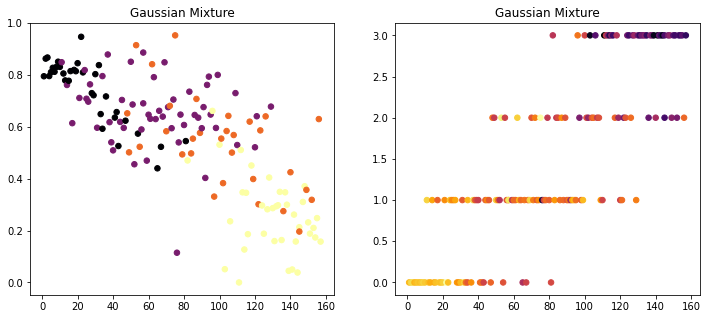

In [0]:
#Gaussian Mixture ones
plt.close()
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1, 2, 1)
ax1=plt.scatter(data['Happiness Rank'],data['Health (Life Expectancy)'], s=30, c=gmm_pred, cmap='inferno')
ax1 = plt.title('Gaussian Mixture')
ax2 = plt.subplot(1, 2, 2)
ax2=plt.scatter(data['Happiness Rank'],gmm_pred, s=30, c=data['Health (Life Expectancy)'], cmap='inferno')
ax2 = plt.title('Gaussian Mixture')

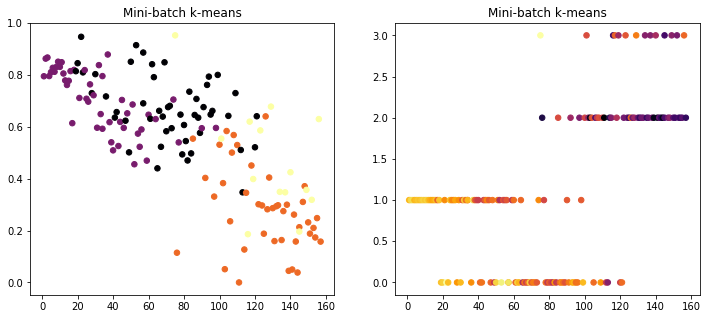

In [0]:
#Mini-batch ones
plt.close()
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1, 2, 1)
ax1=plt.scatter(data['Happiness Rank'],data['Health (Life Expectancy)'], s=30, c=minik_pred, cmap='inferno')
ax1 = plt.title('Mini-batch k-means')
ax2 = plt.subplot(1, 2, 2)
ax2=plt.scatter(data['Happiness Rank'],minik_pred, s=30, c=data['Health (Life Expectancy)'], cmap='inferno')
ax2 = plt.title('Mini-batch k-means')


E' già possibile notare, guardando ai primi grafici di ogni plot, come per questo tipo di feature, mentre Gaussian mixture riesce in qualche modo a descrivere in modo approssimativo 4 fasce distinte, mini-batch ne descrive in buona sostanza due ben distinte, ma nelle quali si mescolano due colori differenti. Ciò è reso ancor più chiaro dai secondi grafici, dove per Gaussian Mixture si ha una divisione graduale evidente, a differenza di minibatch, che presenta la stessa problematica messa in luce in precedenza. <br />
L'andamento complessivo dei plot conferma la relazione supposta tra felicità e aspettativa di vita (Health). <br />
Si procede con il test della feature Economy.

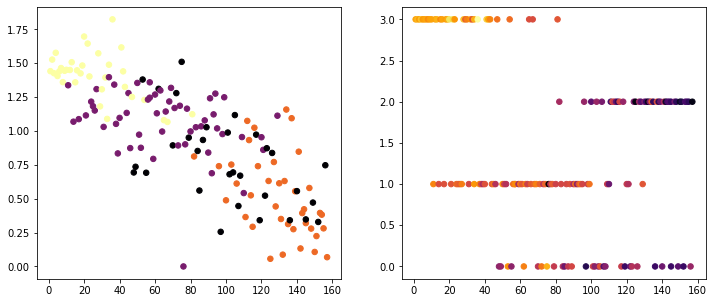

In [0]:
plt.close()
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1, 2, 1)
ax1=plt.scatter(data['Happiness Rank'],data['Economy (GDP per Capita)'], s=30, c=gmm_pred, cmap='inferno')

ax2 = plt.subplot(1, 2, 2)
ax2 = plt.scatter(data['Happiness Rank'],gmm_pred, s=30, c=data['Economy (GDP per Capita)'], cmap='inferno')

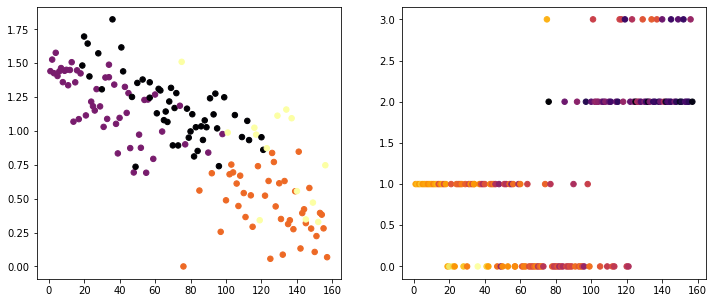

In [0]:
plt.close()
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1, 2, 1)
ax1=plt.scatter(data['Happiness Rank'],data['Economy (GDP per Capita)'], s=30, c=minik_pred, cmap='inferno')

ax2 = plt.subplot(1, 2, 2)
ax2 = plt.scatter(data['Happiness Rank'],minik_pred, s=30, c=data['Economy (GDP per Capita)'], cmap='inferno')


Oltre a mettere in luce le medesime considerazioni sulla maggiore adeguatezza di Gaussian Mixture, si osserva dal plot grafico come questa seconda feature sia probabilmente ancora più pregnante nella distinzione che si vuole operare. <br />
Si procede infine ad un plot 3d delle variabili studiate. Si riportano sugli assi l'Happiness rank, l'Health e l'Economy, e si colora tramite la predizione data da Gaussian Mixture.

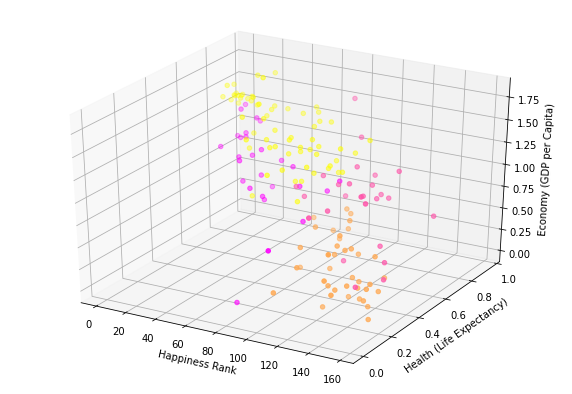

In [0]:
plt.close()
ax = plt.figure(figsize=(10,7)).gca(projection='3d')
ax.scatter(
    xs=data.loc[:,:]["Happiness Rank"], 
    ys=data.loc[:,:]["Health (Life Expectancy)"], 
    zs=data.loc[:,:]["Economy (GDP per Capita)"], 
    c=y_pred, 
    cmap='spring'
)
ax.set_xlabel('Happiness Rank')
ax.set_ylabel('Health (Life Expectancy)')
ax.set_zlabel('Economy (GDP per Capita)')
plt.show()

In seguito a quest'ultima analisi, dato l'andamento del plot 3d, che manifesta una grande correlazione tra le variabili considerate e una buona suddivisione in base alle predizioni operate, si può affermare con decisione come le due feature fondamentali a rendere un paese felice sono il quantitativo di denaro per persona e l'aspettativa di vita.